## Оценка результатов A/B-теста

### Описание задач проекта и технического задания

**Цель исследования:** оценить корректность проведения теста recommender_system_test и проанализировать его результаты.

Чтобы оценить корректность проведения теста: удостоверимся, что нет пересечений с конкурирующим тестом и нет
пользователей, участвующих в двух группах теста одновременно; проверим равномерность распределения пользователей по тестовым группам и правильность их формирования.


**Техническое задание:**
- Название теста: recommender_system_test ;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    
    
    - конверсии в просмотр карточек товаров — событие product_page ,
    - просмотры корзины — product_cart ,
    - покупки — purchase .

### Загрузка данных и изучение общей информации

In [1]:
#импортируем нужные библиотеки
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import scipy.stats as stats
import datetime as dt
import math as mth
#!pip install statsmodels
from statsmodels.stats.proportion import proportions_ztest
#! pip install kaleido
import kaleido
#также отключим предупреждения
import warnings
warnings.filterwarnings('ignore')

In [2]:
#создадим функцию для первичного анализа датафрейма и подсчета явных дубликатов

def df_analyse(df):
    dupl = df.duplicated().sum()
    nan = df.isna().sum()
    
    display(df.head(5))
    print(' ')
    print(f'Кол-во NaN: {nan}')
    print(' ')
    print(f'Явных дубликатов:{dupl}')
    print(' ')
    display (df.info())
    display (df.describe());

In [3]:
#действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года 
final_ab_events = pd.read_csv('/Users/shepe/Downloads/final_ab_events.csv') 

In [4]:
df_analyse(final_ab_events)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


 
Кол-во NaN: user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64
 
Явных дубликатов:0
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


При первичном анализе датафрейма с действиями новых пользователей **не было обнаружено явных дубликатов**. Столбцы проименованы корректно, переименование не требуется. Необходима смена типов данных в столбце event_dt, для уменьшения объема хранения датафрейма также изменим тип данных в столбце details (максимальное значение — 499.99).

**Пропуски данных присутствуют в столбце details**, где хранятся дополнительные данные о событии (например, стоимость покупки при действии purchase). Пропуски в этом столбце закономерны, поскольку не везде может присутствовать дополнительная информация, избавляться от них не будем, поставим заглушку.

Также видим, что в столбце details присутствуют аномалии в данных. 

Необходимо отметить **особенность записи данных в столбце event_dt**: если в браузере у пользователя отключена часть необходимого тесту функционала события могут записываться с одинаковым временем завершения сессии (то есть, фиксировалось не время совершения каждого события, а время завершения всей сессии).

In [5]:
#календарь маркетинговых событий на 2020 год
ab_project_marketing_events = pd.read_csv('/Users/shepe/Downloads/ab_project_marketing_events.csv')

In [6]:
df_analyse(ab_project_marketing_events)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


 
Кол-во NaN: name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
 
Явных дубликатов:0
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Christmas&New Year Promo,APAC,2020-12-25,2021-01-03
freq,1,4,1,1


При первичном анализе датафрейма с маркетинговыми событиями **не было обнаружено пропусков в данных, а также явных дубликатов**. Столбцы проименованы корректно, переименование не требуется. Необходима смена типов данных в столбцах start_dt и finish_dt.

In [7]:
#пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года
final_ab_new_users = pd.read_csv('/Users/shepe/Downloads/final_ab_new_users.csv')

In [8]:
df_analyse(final_ab_new_users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


 
Кол-во NaN: user_id       0
first_date    0
region        0
device        0
dtype: int64
 
Явных дубликатов:0
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,D72A72121175D8BE,2020-12-21,EU,Android
freq,1,6290,46270,27520


При первичном анализе датафрейма с новыми пользователями **не было обнаружено пропусков в данных, а также явных дубликатов**. Столбцы проименованы корректно, переименование не требуется. Необходима смена типов данных в столбце first_date. 

In [9]:
 #таблица участников тестов
final_ab_participants = pd.read_csv('/Users/shepe/Downloads/final_ab_participants.csv')

In [10]:
df_analyse(final_ab_participants)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


 
Кол-во NaN: user_id    0
group      0
ab_test    0
dtype: int64
 
Явных дубликатов:0
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,0FDFDA0B2DEC2D91,A,interface_eu_test
freq,2,9655,11567


In [11]:
final_ab_participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

При первичном анализе датафрейма с участниками тестов **не было обнаружено пропусков в данных, а также явных дубликатов**. Столбцы проименованы корректно, переименование не требуется. Смена типов данных не требуется.

Также мы видим, что **в датафрейме предствлены участники двух конкурирующих тестов: interface_eu_test и recommender_system_test**.

## Предобработка данных

### Заменим типы данных 

In [12]:
final_ab_events = final_ab_events.astype({'event_dt':'datetime64','details':'float32'})

In [13]:
ab_project_marketing_events = ab_project_marketing_events.astype({'start_dt':'datetime64','finish_dt':'datetime64'})

In [14]:
final_ab_new_users = final_ab_new_users.astype({'first_date':'datetime64'})

### Обработка пропусков

Пропуски данных присутствуют только в датафрейме final_ab_events в столбце details, там хранятся дополнительные данные о событии (например, стоимость покупки при действии purchase). 

При первичном анализе мы уже писали, что пропуски в этом столбце закономерны, поскольку не везде может присутствовать дополнительная информация, избавляться от них не будем, поставим заглушку нулем.

In [15]:
final_ab_events.loc[final_ab_events['details'].isna(), 'details'] = 0

### Проверка дубликатов

С помощью первичного анализа мы обнаружили, что явных дубликатов нет ни в одном из датафреймов. Проверим скрытые дубликаты.

In [16]:
final_ab_events.duplicated(['user_id', 'event_dt','event_name']).sum()

0

Неявных дубликатов в final_ab_events нет.

In [17]:
ab_project_marketing_events.duplicated(['name']).sum()

0

Неявных дубликатов в ab_project_marketing_events нет.

In [18]:
final_ab_new_users.duplicated(['user_id']).sum()

0

Неявных дубликатов в final_ab_new_users нет.

In [19]:
final_ab_participants.duplicated(['user_id']).sum()

1602

В датафрейме с участниками тестов **обнаружены дубликаты по уникальному номеру пользователя**: выясним природу этих дубликатов, они могут быть внутри одного теста (пользователь попал в две группы одного теста) или пользователи участвуют в двух конкурирующих тестах.

In [20]:
final_ab_participants.duplicated(['user_id','ab_test']).sum()

0

Мы выяснили, что пользователей, которые попали сразу в две группы одного теста, нет. Дублирующиеся значения уникальных идентификаторов возникли из-за пересечения аудиторий двух тестов. Соответственно, есть пользователи, которые участвуют в двух тестах одновременно. 

In [21]:
dupl_users = final_ab_participants.groupby('user_id',as_index=False).agg(count=('ab_test','count'))\
                                  .sort_values(by='count',ascending=False).query('count > 1')['user_id']

f'Пользователей, участвующих в двух пересекающихся тестах одновременно: {len(dupl_users)}'

'Пользователей, участвующих в двух пересекающихся тестах одновременно: 1602'

Учтем наличие таких пользователей при оценке корректности проведения теста recommender_system_test.

### За какой период представлены данные?

**Регистрация новых пользователей:**

In [22]:
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [23]:
min_date = final_ab_new_users['first_date'].min()
max_date = final_ab_new_users['first_date'].max()
print(f'Минимальная дата регистрации нового пользователя: {min_date}')
print(f'Максимальная дата регистрации нового пользователя: {max_date}')

Минимальная дата регистрации нового пользователя: 2020-12-07 00:00:00
Максимальная дата регистрации нового пользователя: 2020-12-23 00:00:00


Новые пользователи регистрировались в период с 7 декабря по 23 декабря 2020 года. В описании данных указано, что датафрейм содержит информацию о пользователях, зарегистрировавшихся с 7 по 21 декабря. 

Соответственно, либо описание данных неверно, либо пользователи, регистрировавшиеся 22 и 23 декабря попали в датасет по ошибке.

**Действия новых пользователей:**

In [24]:
min_date = final_ab_events['event_dt'].min()
max_date = final_ab_events['event_dt'].max()
print(f'Дата и время первого события в датасете final_ab_events: {min_date}')
print(f'Дата и время последнего события в датасете final_ab_events: {max_date}')

Дата и время первого события в датасете final_ab_events: 2020-12-07 00:00:33
Дата и время последнего события в датасете final_ab_events: 2020-12-30 23:36:33


В данных события представлены за период с 7 декабря до 30 декабря 2020 года.

В описании данных указано, что датасет хранит информацию о событиях пользователей в период с 7 декабря 2020 по 4 января 2021 года. Соответственно, либо пользователи не совершали действий с 31 декабря по 4 января, либо часть данных утеряна.

**Маркетинговые активности:**

In [25]:
min_date_start = ab_project_marketing_events['start_dt'].min()
max_date_start = ab_project_marketing_events['start_dt'].max()

max_date = ab_project_marketing_events['finish_dt'].max()

print(f'Дата начала первой маркетинговой активности в 2020 году: {min_date_start}')
print(f'Дата начала последней маркетинговой активности в 2020 году: {max_date_start}')

print(f'Максимальная дата окончания маркетинговой активности: {max_date}')

Дата начала первой маркетинговой активности в 2020 году: 2020-01-25 00:00:00
Дата начала последней маркетинговой активности в 2020 году: 2020-12-30 00:00:00
Максимальная дата окончания маркетинговой активности: 2021-01-07 00:00:00


Датасет с календарем маркетинговых активностей отражает те активности, которые начались в 2020 году: первая активность 25 января, последняя 30 декабря.

Максимальная дата окончания маркетинговой активности — 7 января. 

### Какие действия совершали пользователи?

In [26]:
final_ab_events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

В датасете с действиями новых пользователей мы видим четыре типа событий: **логин, просмотр карточки товара (product_page), покупка (purchase) и просмотры корзины (product_cart)**. 

По логике путь пользователя предполагается следующий: логин, просмотр карточек, просмотр корзины и покупка. Причем, вероятно, возможна и покупка минуя корзину. 

### Откуда пользователи?

In [27]:
final_ab_new_users['region'].value_counts()

EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64

Большая часть новых пользователей из Европы, также есть жители Северной Америки, СНГ и Азиатско-Тихоокеанского региона (APAC).

## Оценка корректности проведения теста

### Проверим соответствие данных требованиям ТЗ:

**1) дата запуска: 2020-12-07 + дата остановки набора новых пользователей: 2020-12-21 + дата остановки: 2021-01-04**

In [28]:
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [29]:
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Как мы ранее отметили, в датасете с новыми зарегистрировавшимися пользователями есть люди, которые зарегистрировались после 21 декабря (что не соответствует ТЗ). Таких людей не должно быть в нашем тесте. 

In [30]:
#пользователи с регистрацией 
post_users = final_ab_new_users.query("first_date > '2020-12-21'")['user_id']

In [31]:
#создадим срез пользователей нашего теста
rec_final_ab_participants = final_ab_participants.query("ab_test == 'recommender_system_test'")

In [32]:
rec_final_ab_participants.query('user_id.isin(@post_users)')

,user_id,group,ab_test


Пользователи, зарегистрировавшиеся после 21 декабря в тест не попали, ранее 7 декабря пользователи не регистрировались (проверили это на этапе предобработки данных) условие ТЗ выполняется.

**2) дата остановки теста: 2021-01-04**

В данных (final_ab_events) события представлены за период с 7 декабря до 30 декабря 2020 года. Ранее мы писали, что соответственно, либо пользователи не совершали действий с 31 декабря по 4 января, либо часть данных утеряна.

То есть, по сути требование ТЗ не выполняется. Более того, в случае, если часть данных утеряна, необходимо также скорректировать дату остановки набора пользователей: сейчас это 21 декабря, а грамотнее было бы сдвинуть до 16 декабря (чтобы для каждого пользователя было 14 дней лайфтайма).

### Изучим аудиторию теста более подробно

**3)в тест должно быть отобрано 15% новых пользователей из региона EU**

In [33]:
#общее кол-во новых пользователей из Европы
eu_sum = final_ab_new_users.query("region == 'EU' and first_date < '2020-12-21'")['user_id']

In [34]:
#количество пользвоателей нашего теста из Европы
eu_test_sum = rec_final_ab_participants.query("user_id.isin(@eu_sum)")['user_id'].count()

In [35]:
f'В тест было отобрано {round(eu_test_sum/len(eu_sum)*100,2)}% новых пользователей из Европы'

'В тест было отобрано 15.04% новых пользователей из Европы'

Условие ТЗ выполняется. 

**4) ожидаемое количество участников теста: 6000**

In [36]:
rec_final_ab_participants['user_id'].count()

6701

До проверок и изменения данных условие ТЗ выполняется, однако мы уже обнаружили дублирующихся пользователей в двух конкурирующих тестах на этапе предобработки, поэтому после преобразований, количество участников вероятно уменьшится.

**На этапе предобработки данных мы выяснили, что пользователей, которые одновременно попали в группу А (контрольная группа) и в группу В (экспериментальная группа) нашего теста, нет, однако мы обнаружили, что существуют пользователи, которые участвовали и в конкурирующем тесте, решим, что делать с такими пользователями.**

Проведем z-тест на равенство долей пользователей, участвующих в пересекающихся тестах, в обеих группах нашего теста. 

- H0: Между долями нет значимой разницы
- H1: Между долями есть статистически значимая разница

In [37]:
#уровень значимости
alpha = 0.05

#пропорция в группе А

num_dupl_a = len(rec_final_ab_participants.query("user_id.isin(@dupl_users) and group == 'A'")['user_id'])
num_a = len(rec_final_ab_participants.query("group == 'A'")['user_id'])

prop_a = num_dupl_a/num_a

#пропорция в группе B
num_dupl_b = len(rec_final_ab_participants.query("user_id.isin(@dupl_users) and group == 'B'")['user_id'])
num_b = len(rec_final_ab_participants.query("group == 'B'")['user_id'])

prop_b = num_dupl_b/num_b

p_cum= len(dupl_users)/len(rec_final_ab_participants['user_id'])

difference = prop_a-prop_b

z_value = difference/mth.sqrt(p_cum*(1-p_cum)*(1/num_a +1/num_b))# ваш код
distr = stats.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2 

if p_value < alpha:
    print(f'Доля пересекающихся в группе А: {round(prop_a,2)}')
    print(f'Доля пересекающихся в группе B: {round(prop_b,2)}')
    print(f'Уровень значимости: {p_value}')
    print('Отвергаем нулевую гипотезу о равенстве долей')

else:
    print(f'Доля пересекающихся в группе А: {round(prop_a,2)}')
    print(f'Доля пересекающихся в группе B: {round(prop_b,2)}')
    print(f'Уровень значимости: {p_value}')
    print('Не удалось отвергнуть нулевую гипотезу о равенстве долей')

Доля пересекающихся в группе А: 0.24
Доля пересекающихся в группе B: 0.24
Уровень значимости: 0.6939301135009055
Не удалось отвергнуть нулевую гипотезу о равенстве долей


Исходя из статистического теста, не удалось подтвердить статистическую разницу в долях пересекающихся пользователей между двумя группами теста. Поэтому такие пользователи вероятно одинаково повлияют на результаты теста. Можем не избавляться от них.

In [38]:
#убираем столбец с названием теста, поскольку в датафрейме только срез нашего теста
rec_final_ab_participants = rec_final_ab_participants.drop('ab_test',axis=1)

In [39]:
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [40]:
#создадим объединенный датафрейм с регионом пользователя и датой его регистрации 
rec_final_ab_participants = rec_final_ab_participants.merge(final_ab_new_users, how='left')
rec_final_ab_participants

,user_id,group,first_date,region,device
0,D1ABA3E2887B6A73,A,2020-12-07,EU,PC
1,A7A3664BD6242119,A,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,2020-12-08,EU,Mac
3,04988C5DF189632E,A,2020-12-14,EU,iPhone
4,482F14783456D21B,B,2020-12-14,EU,PC
...,...,...,...,...,...
6696,053FB26D6D49EDDC,A,2020-12-10,N.America,Android
6697,9D263B8EF15CF188,B,2020-12-16,N.America,Mac
6698,F2FBBA33F37DEC46,A,2020-12-18,APAC,Mac
6699,29C92313A98B1176,B,2020-12-07,APAC,Android


In [41]:
#проверим, все ли пользователи из Европы
rec_final_ab_participants.groupby(['region','group'],as_index=False).agg(count=('user_id','count'))\
                         .sort_values(by='count',ascending=False)

,region,group,count
4,EU,A,3634
5,EU,B,2717
6,N.America,A,128
7,N.America,B,95
0,APAC,A,37
1,APAC,B,35
3,CIS,B,30
2,CIS,A,25


Поскольку в наш тест должны были попасть только пользователи из Европы, уберем пользователей из других регионов. У нас не совсем равномерное распределение в долях между группами, к тому же их количество более 1%. Поэтому чтобы результаты теста не исказились, избавимся от них.

In [42]:
rec_final_ab_participants = rec_final_ab_participants.query("region == 'EU'")
rec_final_ab_participants

,user_id,group,first_date,region,device
0,D1ABA3E2887B6A73,A,2020-12-07,EU,PC
1,A7A3664BD6242119,A,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,2020-12-08,EU,Mac
3,04988C5DF189632E,A,2020-12-14,EU,iPhone
4,482F14783456D21B,B,2020-12-14,EU,PC
...,...,...,...,...,...
6346,7C5C12FA1B5AB710,A,2020-12-21,EU,Android
6347,91C3969B8A72B908,B,2020-12-09,EU,Android
6348,E26F13A65CEAC6EA,A,2020-12-17,EU,Mac
6349,95401934D6D6D4FC,B,2020-12-13,EU,iPhone


**У нас 6351 уникальных пользователей в двух группах, создадим объединенный датафрейм с событиями:**

In [43]:
rec_final_ab_participants = rec_final_ab_participants.merge(final_ab_events,how='left')

In [44]:
#посчитаем кол-во уникальных пользователей, не совершивших ни одного события
rec_final_ab_participants.query('event_dt.isna()')['user_id'].nunique()

2870

Соответственно, **2870 участников теста не совершили ни одного события**. Однако поскольку наш тест проверяет изменения от рекомендательной системы, нам не интересны пользователи, которые не совершили ни одного действия, они просто никак не могли "дойти" до самого тестируемого изменения, поэтому таких пользователей необходимо убрать. 

Тем не менее, стоит проверить, **какую долю пользователей каждой из групп мы таким образом убираем**:

In [45]:
temp_table = rec_final_ab_participants.query('event_dt.isna()').groupby('group',as_index=False).agg(count=('user_id','count'))

temp_table['share'] = [temp_table['count'][0]/rec_final_ab_participants.query("group == 'A'")['user_id'].nunique(),
                       temp_table['count'][1]/rec_final_ab_participants.query("group == 'B'")['user_id'].nunique()]

temp_table

,group,count,share
0,A,1030,0.283434
1,B,1840,0.677218


Получается, **мы потеряли почти 68% пользователей из группы В**, необходимо проверить, скорее всего здесь была какая-то техническая ошибка в записи данных или сбой в приложении для пользователей, которым внедрили новую рекомендательную систему. 

За счет этого мы потеряли большое количество пользователей из тестовой группы и распределение между двумя группами стало еще более неравномерным.

In [46]:
#обновим рабочий датафрейм, убрав пользователей без дей-ий
rec_final_ab = rec_final_ab_participants.query('~event_dt.isna()')

#сколько уникальных пользователей осталось?
rec_final_ab['user_id'].nunique()

3481

У нас остается 3481 участник.

**После проверки пересечения и удаления других регионов, а также удаления пользователей, не совершивших действия, у нас остается 3481 пользователь — то есть ТЗ нарушается.** Однако такая большая аудитория теста нам может и не понадобится, с помощью калькулятора в дальнейшем мы проверим, какой минимальный размер выборок в двух группах позволит провести достоверный тест.

### Проверим равномерность распределения по тестовым группам и правильность их формирования:

In [47]:
rec_final_ab.groupby('group',as_index=False).agg(count=('user_id','nunique'))

,group,count
0,A,2604
1,B,877


Разница видна невообруженным взглядом, но проверим также **z-тестом на пропорции**.

- Н0: Значимой разницы между долями нет
- Н1: Значимая разница между долями есть

In [48]:
alpha = 0.05
count = np.array([rec_final_ab.groupby('group',as_index=False).agg(count=('user_id','nunique'))['count'][0],
                  rec_final_ab.groupby('group',as_index=False).agg(count=('user_id','nunique'))['count'][1]])
nobs = np.array([rec_final_ab.groupby('group',as_index=False).agg(count=('user_id','nunique'))['count'].sum()
                     , rec_final_ab.groupby('group',as_index=False).agg(count=('user_id','nunique'))['count'].sum()
                     ])
stat, pval = proportions_ztest(count, nobs)
print('Уровень значимости: {0:0.3f}'.format(pval))
if pval<alpha:
    print('Отвергаем нулевую гипотезу о равенстве долей')
else:
    print('Не удалось отвергнуть нулевую гипотезу о равенстве долей')

Уровень значимости: 0.000
Отвергаем нулевую гипотезу о равенстве долей


Мы видим, что группы распределены не равномерно, группа А почти в три раза больше группы В, разница в пропорциях статистически также подтверждена. Отсюда делаем вывод, что любые дальнейшие сравнения нужно проводить в относительных кол-вах (смотреть на равенство долей с помощью z-теста). 

Ранее мы уже проверяли, что не было пользователей, которые попали одновременно в две группы нашего теста, соответственно группы были сформированы корректно с этой точки зрения. Однако несбалансированные выборки — это признак нарушения качества проведения теста. Причем, как мы выяснили, большая часть пользователей тестовой группы не совершала событий — здесь мог быть технический лаг.

**5) ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%**

Мы сможем проверить выполнение этого пункта ТЗ в конце исследования. Однако на текущем этапе необходимо будет проверить соответствие событий указанному лайфтайму и корректность воронки событий. 

Уберем события, которые были совершены вне лайфтайма пользователя (14 дней со дня регистрации)

In [49]:
rec_final_ab = rec_final_ab.loc[(rec_final_ab['first_date'] + dt.timedelta(days=13)) >= rec_final_ab['event_dt']]

#уберем столбец с деталями, поскольку он не пригодится в нашем исследовании
rec_final_ab = rec_final_ab.drop('details',axis=1)

Поскольку, согласно ТЗ, мы тестируем изменения, связанные именно с рекомендательной системой, нам не интересен для анализа конверсия переходов от регистраций до логина, поскольку нам в принципе не интересно событие login. Чтобы рекомендательная система могла повлиять на поведение пользователя, он должен априори зайти в приложение, до этого момента на него могут влиять другие факторы, но только не рекомендательная система.

**Поэтому воронку пользователя для нашего теста мы сформируем следующим образом**:

- логин (оставляем для подсчета конверсии в просмотры карточек)
- просмотр карточек товаров — событие product_page 
- просмотры корзины — product_cart 
- покупка — purchase 

In [50]:
#посмотрим на предварительный общий подсчет воронки по кол-ву совершенных событий
rec_final_ab.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='count')\
             .sort_values(by='B',ascending=False).reset_index()

group,event_name,A,B
0,login,7819,2285
1,product_page,5027,1226
2,product_cart,2332,614
3,purchase,2463,611


In [51]:
#подсчет кол-ва разных событий на пользователя
rec_final_ab.groupby(['user_id','event_name'],as_index=False).agg(count=('user_id','count')).sort_values(by='count',ascending=False)

,user_id,event_name,count
6410,D182471A77C0DC13,product_page,7
5035,A7A055BA12053CBA,product_page,7
498,115EBC1CA027854A,product_page,7
497,115EBC1CA027854A,product_cart,7
496,115EBC1CA027854A,login,7
...,...,...,...
6117,C76AB3B4FB0A87B6,login,1
7020,E6AAFF21D051CC65,login,1
2792,5C85C417F02FEDCF,login,1
2793,5C85C417F02FEDCF,product_page,1


In [52]:
#посмотрим на предварительный общий подсчет воронки по уникам (по ТЗ нам нужно именно улучшение пользователей)
ab_funnel = rec_final_ab.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')\
             .sort_values(by='B',ascending=False).reset_index()

#установим нужный порядок событий в воронке
ab_funnel = ab_funnel.reindex([0,1,3,2]).reset_index(drop=True)
ab_funnel

group,event_name,A,B
0,login,2604,876
1,product_page,1685,493
2,product_cart,782,244
3,purchase,833,249


С помощью предварительного анализа мы увидели, что:

- один пользователь мог совершать несколько одинаковых действий (самое большое кол-во 7)
- купить продукты можно было без перехода в корзину, напрямую после просмотра карточки

**Сформируем воронку с конверсией от первого шага (логин) и конверсию перехода от одного шага в другой:**

In [53]:
ab_funnel['conv_rate_a'] = round(ab_funnel["A"] / ab_funnel["A"][0],3)
ab_funnel['conv_rate_b'] = round(ab_funnel["B"] / ab_funnel["B"][0],3)

In [54]:
ab_funnel = ab_funnel.assign(a_conv_per_step= lambda x:
                             (round(x['A'] / x['A'].shift(),3)).fillna(1))
ab_funnel = ab_funnel.assign(b_conv_per_step= lambda x:
                             (round(x['B'] / x['B'].shift(),3)).fillna(1))

ab_funnel

group,event_name,A,B,conv_rate_a,conv_rate_b,a_conv_per_step,b_conv_per_step
0,login,2604,876,1.000,1.000,1.000,1.000
1,product_page,1685,493,0.647,0.563,0.647,0.563
2,product_cart,782,244,0.300,0.279,0.464,0.495
3,purchase,833,249,0.320,0.284,1.065,1.020


Возьмем самый высокий уровень базовой конверсии (в контрольной группе), с помощью калькулятора размера выборки мы определили, что нам достаточно 366 пользователей в выборке, чтобы корректно провести тест и отследить изменения в 10%.

Получается, несмотря на несоответствие пункту ТЗ про аудиторию, с такими тестовыми группами мы можем проводить тест.

### Проанализируем время проведения теста (что на тест не повлияли маркетинговые и другие активности)

In [55]:
#посмотрим на датасет с событиями
ab_project_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Так как нам интересны только события, проходящие в Европе, сделаем срез активностей по региону:

In [56]:
eu_marketing = ab_project_marketing_events.query("regions.str.contains('EU')")
eu_marketing

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10


**Поскольку у нас небольшое количество мероприятий, будет быстрее и эффективнее отследить пересечения с помощью визуализации:**

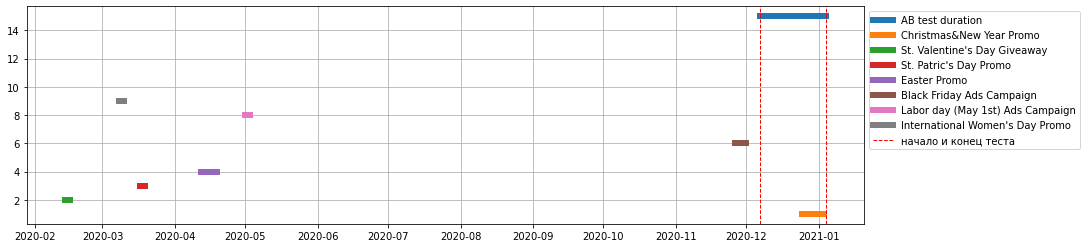

In [57]:
y = np.arange(1,15)

plt.figure(figsize=(15,4))

test_date = pd.to_datetime(['2020-12-07', '2021-01-04'])
y__test_list = [15, 15]
plot = plt.plot(test_date, y__test_list, label='AB test duration', linewidth = 6.0)

for index, x in eu_marketing.iterrows():
    
    merged_date = [x['start_dt'], x['finish_dt']]
    y_list = [y[index], y[index]]
    plt.plot(merged_date, y_list, label=x['name'], linewidth = 6.0)

plt.axvline(x=test_date[0], color='r', linestyle='--',label='начало и конец теста',linewidth = 1.0)
plt.axvline(x=test_date[1], color='r', linestyle='--',linewidth = 1.0)
plt.grid()
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

Соответственно, мы видим одно событие, которое могло повлиять на тест: 

- **Christmas&New Year Promo (Началось во время периода проведения теста, закончилось во время)**

Мог повлиять на пользователей, поскольку направлен в том числе и на аудиторию Европы. Необходимо рассмотреть в дальнейшем, были ли в даты проведения маркетинговой активности (25 декабря — 3 января) какие-то изменения, нехарактерный поворот теста. На основе этого можно будет сделать окончательный вывод, поскольку у нас нет данных о том, какие именно пользователи и из каких групп могли видеть активность (равномерно ли они видели в двух группах).

Но в качестве рекомендации однозначно вынесем, что следует разводить маркетинговые активности и тестирование новых функций, чтобы избежать внешнего влияния.

## Исследовательский анализ данных

### Количество событий на пользователя одинаково распределены в выборках?

Визуализируем распределение:

In [58]:
#подготовим таблицу
temp_table = rec_final_ab.groupby(['user_id','group'],as_index=False).agg(count=('event_name','count'))

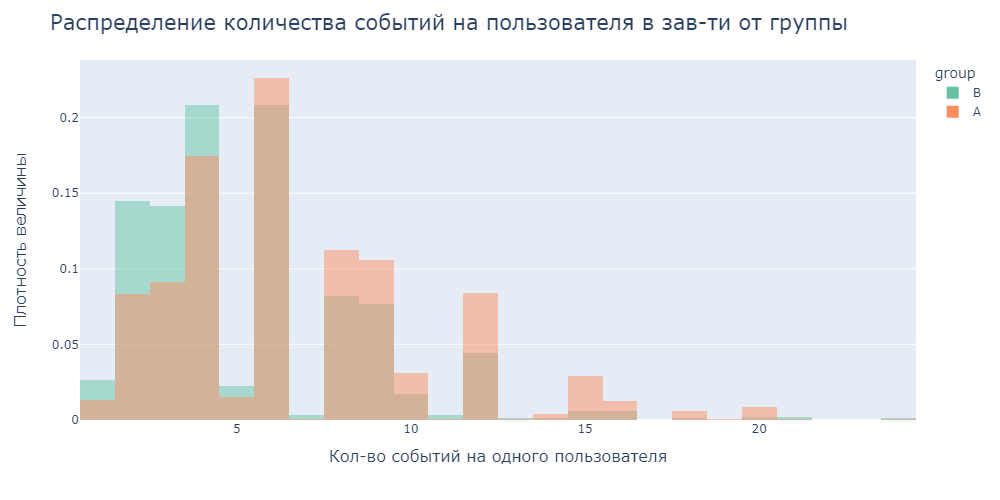

In [59]:
fig = px.histogram(temp_table, 
                   x='count',
                   color='group', 
                   nbins=25, 
                   barmode='overlay',
                   histnorm='probability density',
                   color_discrete_sequence=px.colors.qualitative.Set2
                  ) 

fig.update_layout(title=f'Распределение количества событий на пользователя в зав-ти от группы', 
                   title_font=dict(size=21))
fig.update_xaxes(title_text='Кол-во событий на одного пользователя',title_font=dict(size=16))
fig.update_yaxes(title_text='Плотность величины',title_font=dict(size=16))
fig.show(renderer='png', width = 1000, scale = None)

Количество событий на пользователя распределено в двух выборках не равномерно: в контрольной группе чаще, чем в тестовой, на одного пользователя приходится большее кол-во событий (более 6) и наоборот, в тестовой группе чаще, чем в контрольной встречается меньшее кол-во событий на пользователя (до 6).

Самое часто встречающееся кол-во событий на пользователя в контрольной группе — 6, в тестовой — 4 и 6. 

О чем это может нам говорить? Здесь сложно сказать однозначно, например, это может быть связано с тем, что пользователи меньше думают и возвращаются к действиям (что говорит в пользу новой функции) или же наоборот их ничего не заинтересовывает, потому что рекомендательная система плохо функционирует и они не возвращаются к просмотру товаров и мыслям о покупке.

Сказать более точно возможно будет после анализа результатов теста.

### Как число событий в выборках распределено по дням?

Ранее мы уже писали о том, что поскольку выборки распределены неравномерно, сравнивать их в абслютных значениях будет не показательно. Поэтому посмотрим на распределение числа событий по дням в выборках в абсолютной величине и относительной (доля от общего кол-ва событий в группе).

In [60]:
#подготовим данные
temp_table = rec_final_ab
temp_table['event_dt'] = pd.to_datetime(temp_table['event_dt']).dt.date

num_a = rec_final_ab.query("group == 'A'")['user_id'].nunique()
num_b = rec_final_ab.query("group == 'B'")['user_id'].nunique()

event_a = rec_final_ab.query("group == 'A'")['event_name'].count()
event_b = rec_final_ab.query("group == 'B'")['event_name'].count()

temp_table = temp_table.groupby(['event_dt','group'],as_index=False).agg(nun_users=('user_id','nunique'),
                                                                         event_count = ('event_name','count'))

temp_table.loc[temp_table['group'] == 'A','nun_users'] = temp_table['nun_users']/num_a
temp_table.loc[temp_table['group'] == 'B','nun_users'] = temp_table['nun_users']/num_b 

temp_table['event_share'] = temp_table['event_count']
temp_table.loc[temp_table['group'] == 'A','event_share'] = temp_table['event_share']/event_a
temp_table.loc[temp_table['group'] == 'B','event_share'] = temp_table['event_share']/event_b 

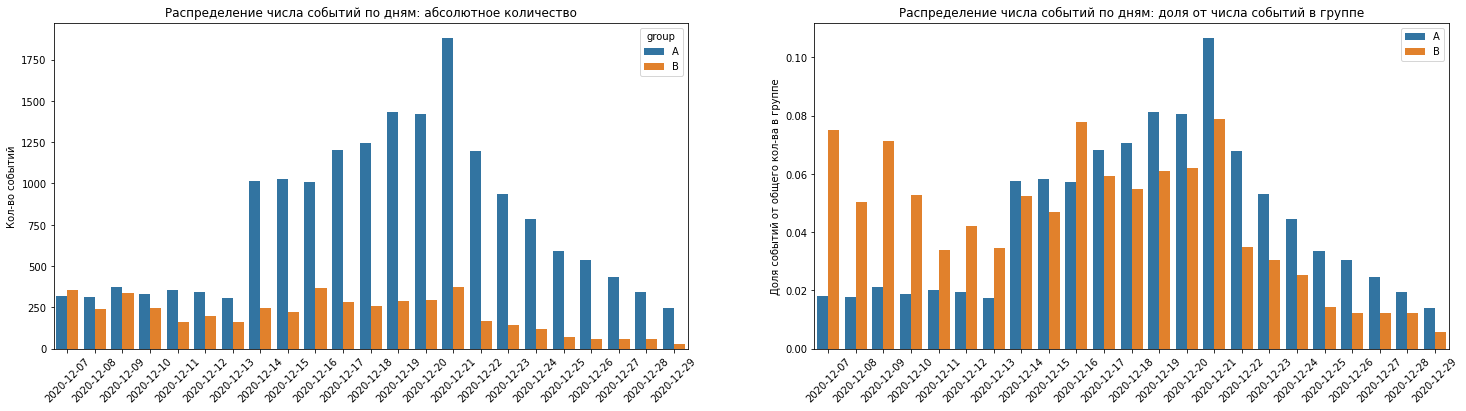

In [61]:
fig, (ax1, ax2) = plt.subplots(1,ncols = 2,figsize=(25,6))

ax1 = sns.barplot(data=temp_table, x='event_dt',y='event_count',hue='group',ax=ax1)
ax1.set_title('Распределение числа событий по дням: абсолютное количество')
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
ax1.set_xlabel('')
ax1.set_ylabel('Кол-во событий')

ax1 = sns.barplot(data=temp_table, x='event_dt',y='event_share',hue='group',ax=ax2)
ax2.set_title('Распределение числа событий по дням: доля от числа событий в группе')
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45)
ax2.set_xlabel('')
ax1.set_ylabel('Доля событий от общего кол-ва в группе')

plt.legend()
plt.show()

Что можно отметить сразу:

- Во-первых, на графике мы видим, что в тесте представлены события **только за период с 7 декабря по 29 декабря**. Ранее мы уже отмечали, что здесь имеет место технический сбой, поскольку пользователи не совершали действий 5 дней. Разумеется, здесь могли повлиять новогодние праздники, однако это больше похоже на сбой. **Необходимо либо ограничить набор в тест за 14 дней до даты последнего события — чтобы у всех пользователей были две недели. Или добавить недостающие данные, если это возможно.**

- Во-вторых, маркетинговая активность, с которой было пересечение, судя по графику, **значительно не повлияла** на ход теста (ее начало — 25 декабря). Тем не менее, в будущем необходимо избегать подобных перечений при проведении тестов.

Теперь рассмотрим подробно распределение числа событий по дням:

- в тестовой группе оно визуально более равномерное, нежели в контрольной. Для группы А мы видим внезапный и довольно **сильный всплеск в районе 14 декабря**. Возникает предположение о каком-либо внешнем влиянии, которое могло спровоцировать такой всплеск (возможно, пиар-компания или акции/розыгрыши, которые не фиксировались в календаре маркетинговых событий). Пик этого подъема в группе А приходится на 20 декабря, затем мы наблюдаем снижение числа совершаемых событий.

Здесь необходимо проверить влияние неучтенных внешних факторов. Если таких нет, возможно подобное поведение связано с сезонностью (за две недели до Нового года пользователи стали более активны). Однако этот фактор также негативно сказывается на достоверности проводимого теста. Не стоит проводить тестирование в периоды, где возможно аномальное поведение пользователей (ажиотаж в предпраздничный период и пр.) и влияние большого количества скрытых факторов. 

- в тестовой группе сначала мы видим значительное лидирование по доле событий в день, однако после 9 декабря начинается небольшой спад, а затем небольшой подъем.

### Посмотрим дополнительно, как распределились регистрации пользователей, не был ли скачок в группе А связан именно со скачком регистраций?

In [62]:
#подготовим данные 
temp_table = rec_final_ab
temp_table['first_date'] = pd.to_datetime(temp_table['first_date']).dt.date
temp_table = temp_table.groupby(['first_date','group'],as_index=False).agg(
                                                                         reg_count = ('user_id','nunique'))

temp_table['reg_share'] = temp_table['reg_count']
temp_table.loc[temp_table['group'] == 'A','reg_share'] = temp_table['reg_share']/num_a
temp_table.loc[temp_table['group'] == 'B','reg_share'] = temp_table['reg_share']/num_b 

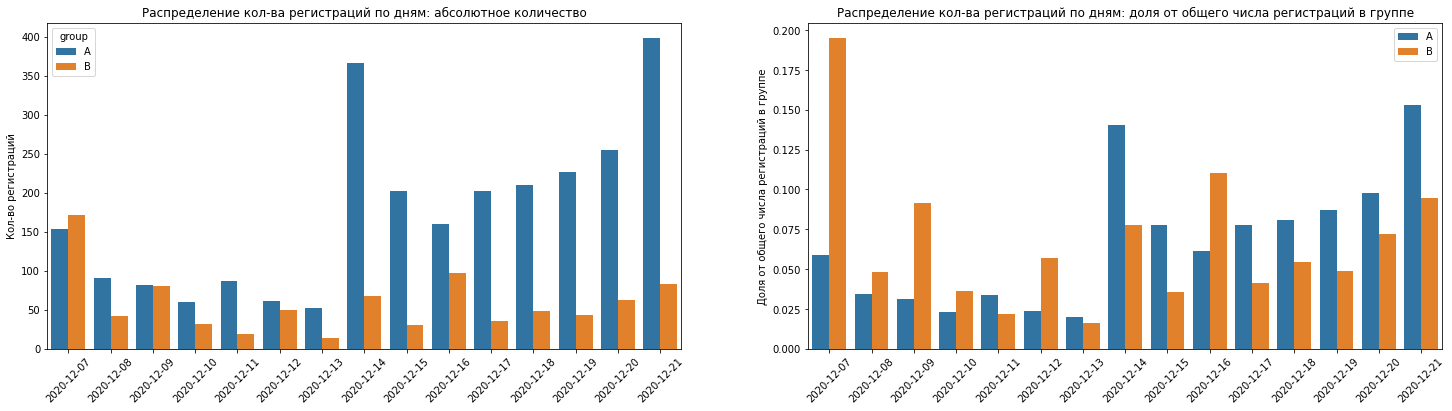

In [63]:
fig, (ax1, ax2) = plt.subplots(1,ncols = 2,figsize=(25,6))

ax1 = sns.barplot(data=temp_table, x='first_date',y='reg_count',hue='group',ax=ax1)
ax1.set_title('Распределение кол-ва регистраций по дням: абсолютное количество')
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
ax1.set_xlabel('')
ax1.set_ylabel('Кол-во регистраций')

ax1 = sns.barplot(data=temp_table, x='first_date',y='reg_share',hue='group',ax=ax2)
ax2.set_title('Распределение кол-ва регистраций по дням: доля от общего числа регистраций в группе')
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45)
ax2.set_xlabel('')
ax1.set_ylabel('Доля от общего числа регистраций в группе')

plt.legend()
plt.show()

Как раз 14 декабря мы видим резкий всплеск регистраций в контрольной группе, также 21 числа кол-во регистраций сильно возрасло, однако это не сильно отразилось на распределении событий. Такое распределение регистраций подтверждает гипотезу о внешнем скрытом влиянии на тест. Необходимо разобраться, что могло спровоцировать такой скачок. Вероятно, тест может быть признан некорректным.

В группе В всплеск регистраций наблюдается в первый день набора пользователей. Далее распределение более равномерное, хотя с 14 декабря также есть тренд на повышение кол-ва регистраций.

### Как меняется конверсия в воронке в выборках на разных этапах?

Ранее мы уже подготовили датафрейм с конверсией по отношению к первому шагу и конверсией на каждом этапе. При более детальном изучении данных было обнаружено, что шаг с корзиной не являлся обязательным, соответственно пошаговая конверсия мало что может нам сказать о данных, поскольку вероятно в функциональности приложения есть возможность обходить этот шаг воронки, то есть **воронка не последовательная**.

In [64]:
ab_funnel

group,event_name,A,B,conv_rate_a,conv_rate_b,a_conv_per_step,b_conv_per_step
0,login,2604,876,1.000,1.000,1.000,1.000
1,product_page,1685,493,0.647,0.563,0.647,0.563
2,product_cart,782,244,0.300,0.279,0.464,0.495
3,purchase,833,249,0.320,0.284,1.065,1.020


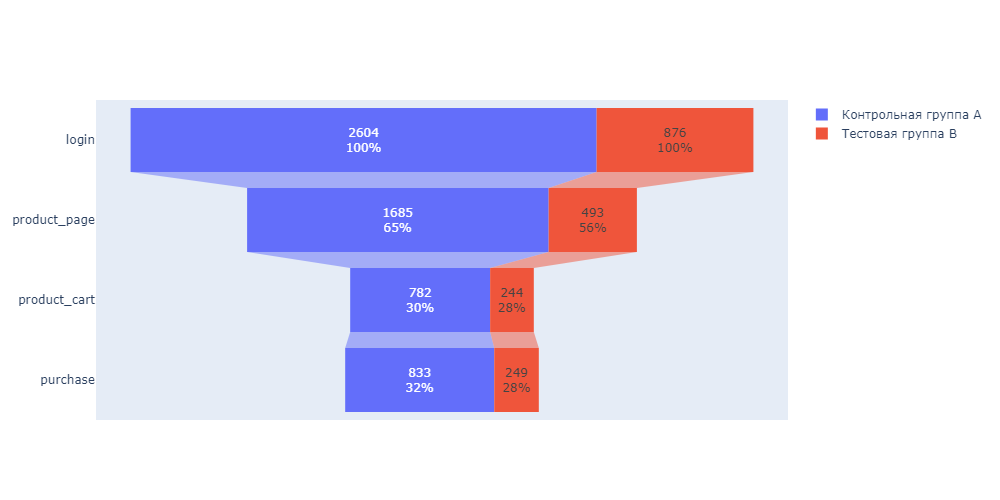

In [65]:
#визуализируем воронку
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Контрольная группа А',
    y = ab_funnel['event_name'],
    x = ab_funnel['A'], 
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Тестовая группа В',
    orientation = "h",
    y = ab_funnel['event_name'],
    x = ab_funnel['B'],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.show(renderer='png', width = 1000, scale = None) 

Результаты в обеих группах достаточно хорошие: **целевое действие совершила почти треть (28%) тестовой группы и более трети (32%) контрольной группы.** На этом этапе мы уже видим, что по конверсии не то чтобы нет улучшений, но есть ухудшения.

Ранее уже говорили о том, что среди пользователей тестовой группы было крайне высокое количество клиентов с нулевыми действиями, что сигнализирует о сбое в сборе данных или приложении. Это могло повлиять на результаты теста.

Более того, в техническом задании не зафиксировано, на каком этапе пользователь может столкнуться с новой рекомендательной системой. Если, например, только на этапе корзины (предлагаются похожие товары и т.д.), то наш тест нельзя назвать показательным, поскольку этот этап можно пропускать и мы не можем отследить, что повлияло на покупку. 

In [66]:
#создадим удобный для анализа датафрейм, чтобы посмотреть, как пользователи совершали покупку: через корзину или вне нее

temp_table = rec_final_ab.query("event_name == 'product_cart' or event_name == 'purchase' ")
temp_table = temp_table.groupby(['user_id', 'group','event_name'], as_index=False).agg(count=('event_name','nunique'))\
                       .sort_values(by='user_id')

temp_table = pd.pivot_table(temp_table, index=['user_id','group'], columns=['event_name'], aggfunc='sum',
              fill_value=0).reset_index()

temp_table.columns=['user_id','group','product_cart','purchase']

In [67]:
#сколько пользователей совершили покупку, но не заходили в корзину
temp_table.query("product_cart == 0 and purchase == 1").groupby('group',as_index=False).agg({'user_id':'count'})

,group,user_id
0,A,572
1,B,174


In [68]:
#сколько пользователей не совершили покупку, но заходили в корзину
temp_table.query("product_cart == 1 and purchase == 0").groupby('group',as_index=False).agg({'user_id':'count'})

,group,user_id
0,A,521
1,B,169


In [69]:
#пользователи, которые совершили покупку через корзину
temp = temp_table.query("product_cart == 1 and purchase == 1").groupby('group',as_index=False).agg({'user_id':'count'})
temp

,group,user_id
0,A,261
1,B,75


Получается, что в обеих группах бОльшая доля пользователей совершила покупку напрямую, без перехода в корзину:

- в группе А 572 из 833
- в группе В 174 из 249

Шаговая конверсия из корзины в покупку для тех пользователей, кто шел четко по воронке:

In [70]:
#группа А
round(temp.query("group == 'A'").iloc[0]['user_id']/ab_funnel.query("event_name == 'product_cart'").iloc[0]['A'],2)

0.33

In [71]:
#группа B
round(temp.query("group == 'B'").iloc[0]['user_id']/ab_funnel.query("event_name == 'product_cart'").iloc[0]['B'],2)

0.31

Таким образом, очень важно прояснить, на каком этапе пользователи могут столкнуться с рекомендательной системой. Если только на этапе корзины, необходимо будет убрать события пользователей, которые совершали покупки напрямую. Это может скорректировать результаты теста + также в этом случае нам может не хватить размера выборки.

## Оценка результатов A/B-тестирования

### Проверим статистическую разницу долей z-критерием

- Н0: Значимой разницы между долями (конверсиями от первого шага) в событие в группах А и В нет
- Н1: Значимая разница между долями (конверсиями от первого шага) в событие группах А и В присутствует

In [72]:
#уровень значимости
alpha = 0.05/3 #поправка на множественный тест

for i in range(1,4):
    #пропорция в группе А

    num_a = ab_funnel['A'][i]
    cum_num_a = ab_funnel['A'][0]
    prop_a = ab_funnel['conv_rate_a'][i]

    #пропорция в группе B
    num_b = ab_funnel['B'][i]
    cum_num_b = ab_funnel['B'][0]
    prop_b = ab_funnel['conv_rate_b'][i]

    p_cum= (num_a + num_b)/(cum_num_a+cum_num_b)

    difference = prop_a-prop_b

    z_value = difference/mth.sqrt(p_cum*(1-p_cum)*(1/num_a +1/num_b))# ваш код
    distr = stats.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2 
    name = ab_funnel['event_name'][i]
    
    print(f'Проверка конверсии в событие {name}')
    print(f'Уровень значимости: {p_value}')
    print(f'Конверсия в группе А: {round(prop_a,3)}')
    print(f'Конверсия в группе B: {round(prop_b,3)}')

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу о равенстве долей')

    else:
        print('Не удалось отвергнуть нулевую гипотезу о равенстве долей')
    
    print(' ')

Проверка конверсии в событие product_page
Уровень значимости: 0.000698550658491115
Конверсия в группе А: 0.647
Конверсия в группе B: 0.563
Отвергаем нулевую гипотезу о равенстве долей
 
Проверка конверсии в событие product_cart
Уровень значимости: 0.5299541639197825
Конверсия в группе А: 0.3
Конверсия в группе B: 0.279
Не удалось отвергнуть нулевую гипотезу о равенстве долей
 
Проверка конверсии в событие purchase
Уровень значимости: 0.28155076643467325
Конверсия в группе А: 0.32
Конверсия в группе B: 0.284
Не удалось отвергнуть нулевую гипотезу о равенстве долей
 


### Что можно сказать про результаты A/В-тестирования?

**По результатам тестирования удалось зафиксировать статистически значимую разницу только между конверсиями в двух группах по событию просмотра карточек товаров. Причем исходя из данных, конверсия в тестируемой группе ниже.**

По конверсии в другие события (просмотр корзины и покупка) не удалось зафиксировать статистически значимых различий между группами.

Ожидаемый эффект (за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%) не достигнут. 

Соответственно, если бы не было зафиксировано нарушений в проведении теста и не было бы предположений на основе данных о технических сбоях, мы могли бы сказать, что новая рекомендательная система не только не улучшила целевые показатели на 10% пунктов, но и по одному событию были зафиксированы ухудшения. То есть, внедрение этой системы не улучшает никаких показателей.

Однако учитывая все зафиксированные сбои и нарушения ТЗ, пересечение с маркетинговыми активностями и возможное внешнее влияние других скрытых факторов на течение теста, а также вероятный технический сбой для тестовой группы, рекомендуется выяснить причины этих нарушений и возможно пересмотреть результаты тестирования или провести новое тестирование. Поскольку в текущей ситуации результатам доверять не рекомендуется.

## Выводы

## При анализе результатов тестирования были выявлены **факторы, которые свидетельствуют о некорректности проведенного теста**:

- **Неравномерное распределение групп, некорректное формирование групп**

В тест попали пользователи не только из целевого региона (Европы).

Были зафиксированы пересекающиеся пользователи из конкурирующего теста. Исходя из статистического теста, не удалось подтвердить статистическую разницу в долях пересекающихся пользователей между двумя группами теста. Поэтому такие пользователи вероятно одинаково повлияли на результаты теста — было принято решение не избавляться от них. 

Итоговые группы распределены неравномерно, группа А почти в три раза больше группы В, разница в пропорциях статистически также подтверждена. Не было пользователей, которые попали одновременно в две группы нашего теста, соответственно группы были сформированы корректно с этой точки зрения. Однако несбалансированные выборки — это признак нарушения качества проведения теста. 

Также ИАД показал, что количество событий на пользователя распределено в двух выборках неравномерно: в контрольной группе чаще, чем в тестовой, на одного пользователя приходится большее кол-во событий (более 6) и наоборот, в тестовой группе чаще, чем в контрольной встречается меньшее кол-во событий на пользователя (до 6).

- **Наличие пользователей с нулевым количеством действий с сильным перекосом в группу В (что может говорить о сбое в сборе данных или других технических сбоях)**

Мы потеряли почти 68% пользователей из группы В, которые не совершали ни одного действия. Необходимо проверить, скорее всего, здесь была какая-то техническая ошибка в записи данных или сбой в приложении для пользователей, которым внедрили новую рекомендательную систему. За счет этого мы потеряли большое количество пользователей из тестовой группы и распределение между двумя группами стало еще более неравномерным. 

- **Пересечение с маркетинговыми активностями и возможное влияние других внешних факторов, о которых мы сделали предположение в ИАД**

Мы зафиксировали одно событие, которое могло повлиять на тест: Christmas&New Year Promo (Началось во время периода проведения теста, закончилось во время). ИАД показал, что маркетинговая активность, с которой было пересечение, судя по графику, значительно не повлияла на ход теста (ее начало — 25 декабря). Тем не менее, в будущем необходимо избегать подобных перечений при проведении тестов.

При изучении распределения числа событий по дням для группы А мы зафиксировали внезапный и довольно сильный всплеск в районе 14 декабря. Возникает предположение о каком-либо внешнем влиянии, которое могло спровоцировать такой всплеск (возможно, пиар-компания или акции/розыгрыши, которые не фиксировались в календаре маркетинговых событий). Пик этого подъема в группе А приходится на 20 декабря, затем мы наблюдаем снижение числа совершаемых событий. Здесь необходимо проверить влияние неучтенных внешних факторов. Если таких нет, возможно подобное поведение связано с сезонностью (за две недели до Нового года пользователи стали более активны). Однако этот фактор также негативно сказывается на достоверности проводимого теста. Не стоит проводить тестирование в периоды, где возможно аномальное поведение пользователей (ажиотаж в предпраздничный период и пр.) и влияние большого количества скрытых факторов.

Как раз 14 декабря мы также увидели резкий всплеск регистраций в контрольной группе, также 21 числа кол-во регистраций сильно возрасло, однако это не сильно отразилось на распределении событий. Такое распределение регистраций подтверждает гипотезу о внешнем скрытом влиянии на тест. Необходимо разобраться, что могло спровоцировать такой скачок. Вероятно, тест может быть признан некорректным. В группе В с 14 декабря также есть тренд на повышение кол-ва регистраций.

- **Непрямая воронка данных (покупку можно совершать как напрямую, так и через корзину)**

В техническом задании не зафиксировано, на каком этапе пользователь может столкнуться с новой рекомендательной системой. Если, например, только на этапе корзины (предлагаются похожие товары и т.д.), то наш тест нельзя назвать показательным, поскольку этот этап можно пропускать и мы не можем отследить, что повлияло на покупку.

Получается, что в обеих группах бОльшая доля пользователей совершила покупку напрямую, без перехода в корзину (в группе А 572 из 833, в группе В 174 из 249)

Таким образом, очень важно прояснить, на каком этапе пользователи могут столкнуться с рекомендательной системой. Если только на этапе корзины, необходимо будет убрать события пользователей, которые совершали покупки напрямую. Это может скорректировать результаты теста + также в этом случае нам может не хватить размера выборки.

- **Временной промежуток предоставленных данных не соответствует ТЗ: в нашем датасете события до 29 декабря включительно, то есть по каким-то причинам нет данных по действиям пользователей за 5 дней**

В данных (final_ab_events) события представлены за период с 7 декабря до 29 декабря 2020 года. То есть, по сути требование ТЗ не выполняется. Более того, в случае, если часть данных утеряна, необходимо также скорректировать дату остановки набора пользователей: сейчас это 21 декабря, а грамотнее было бы сдвинуть до 16 декабря (чтобы для каждого пользователя было 14 дней лайфтайма). Или добавить недостающие данные, если это возможно.

## **Результаты теста:**

- По результатам тестирования удалось зафиксировать статистически значимую разницу только **между конверсиями в двух группах по событию просмотра карточек товаров**. Причем исходя из данных, конверсия в тестируемой группе ниже.

- По конверсии в другие события (просмотр корзины и покупка) не удалось зафиксировать статистически значимых различий между группами.

Ожидаемый эффект (за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%) не достигнут.

Соответственно, если бы не было зафиксировано нарушений в проведении теста и не было бы предположений на основе данных о технических сбоях, мы могли бы сказать, что новая рекомендательная система не только не улучшила целевые показатели на 10% пунктов, но и по одному событию были зафиксированы ухудшения. То есть, внедрение этой системы не улучшает никаких показателей.

Однако учитывая все зафиксированные сбои и нарушения ТЗ, пересечение с маркетинговыми активностями и возможное внешнее влияние других скрытых факторов на течение теста, а также вероятный технический сбой для тестовой группы, рекомендуется выяснить причины этих нарушений и возможно пересмотреть результаты тестирования или провести новое тестирование. Поскольку в текущей ситуации результатам доверять не рекомендуется.

## **Рекомендации:**

- Поскольку тест уже проведен и бюджет на него потрачен, в первую очередь **рекомендуем попытаться выяснить причины сбоев в данных** (почему нет событий с 30 декабря по 4 января, почему такой большой процент пользователей тестовой группы не совершил ни одного действия). Если удастся восстановить часть данных, в случае если они не утрачены, можно будет пересмотреть результаты теста. Если нет, необходимо убрать пользователей, зарегистрированных после 16 декабря

- **Выяснить природу всплеска в количестве действий и регистраций 14 декабря**. Могли ли здесь повлиять скрытые факторы? Возможно, пиар-компания или акции/розыгрыши, которые не фиксировались в календаре маркетинговых событий и пр.

- Выяснить **причину попадания в тест пользователей из других регионов** — возможно нарушены правила набора, был технический сбой

- **Не пересекать аудитории конкурирующих тестов**, это затрудняет анализ результатов

- Стремиться к **равномерному распределению выборок двух тестируемых групп**, отслеживать сбалансированность групп при наборе пользователей на тест

- **Не стоит проводить тестирование в периоды, где возможно аномальное поведение пользователей** (ажиотаж в предпраздничный период и пр.) и влияние большого количества скрытых факторов. Также следует разводить маркетинговые активности и тестирование новых функций, чтобы избежать внешнего влияния.